In [38]:
# BNN on UCI Energy (ENB2012_data.xlsx)
# 读取数据 → 划分 → 标准化 → 变分 BNN → MC 采样出均值/方差 + 区间覆盖率

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# 1. 读数据 + 划分 + 标准化
# =========================
# 确保已安装 openpyxl：pip/conda install openpyxl
df = pd.read_excel("data/ENB2012_data.xlsx")

# 前 8 个特征
X = df.iloc[:, :8].values.astype(np.float32)
# Y1: Heating Load
y = df.iloc[:, 8].values.astype(np.float32).reshape(-1, 1)

print("Raw:", X.shape, y.shape)  # (768, 8), (768, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train = scaler_x.transform(X_train)
X_test  = scaler_x.transform(X_test)
y_train = scaler_y.transform(y_train)
y_test  = scaler_y.transform(y_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=64,
    shuffle=True
)

Raw: (768, 8) (768, 1)
Train: torch.Size([614, 8]) torch.Size([614, 1])
Test : torch.Size([154, 8]) torch.Size([154, 1])


In [39]:
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 假设：X_train, y_train, X_test, y_test, scaler_y, device 等前面都已准备好

# =========================
# 2. Bayes 线性层 + BNN（与你的一样）
# =========================
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.weight_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.full((out_features, in_features), -5.0))
        self.bias_mu   = nn.Parameter(torch.zeros(out_features))
        self.bias_rho  = nn.Parameter(torch.full((out_features,), -5.0))

        self.prior_mu    = 0.0
        self.prior_sigma = 1.0

    def sample_weights(self):
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma   = torch.log1p(torch.exp(self.bias_rho))

        eps_w = torch.randn_like(weight_sigma)
        eps_b = torch.randn_like(bias_sigma)

        weight = self.weight_mu + weight_sigma * eps_w
        bias   = self.bias_mu   + bias_sigma * eps_b
        return weight, bias, weight_sigma, bias_sigma

    def kl_divergence(self, weight, bias, weight_sigma, bias_sigma):
        prior_var = self.prior_sigma ** 2
        kl_w = (torch.log(self.prior_sigma / weight_sigma)
                + (weight_sigma**2 + (weight - self.prior_mu)**2) / (2 * prior_var)
                - 0.5).sum()
        kl_b = (torch.log(self.prior_sigma / bias_sigma)
                + (bias_sigma**2 + (bias - self.prior_mu)**2) / (2 * prior_var)
                - 0.5).sum()
        return kl_w + kl_b

    def forward(self, x):
        weight, bias, w_sigma, b_sigma = self.sample_weights()
        out = x @ weight.t() + bias
        kl = self.kl_divergence(weight, bias, w_sigma, b_sigma)
        return out, kl


class BayesianMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super().__init__()
        self.blinear1 = BayesianLinear(in_dim, hidden_dim)
        self.blinear2 = BayesianLinear(hidden_dim, out_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        h, kl1 = self.blinear1(x)
        h = self.act(h)
        out, kl2 = self.blinear2(h)
        return out, kl1 + kl2

model = BayesianMLP(in_dim=8, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss = nn.MSELoss(reduction="mean")

# =========================
# 3. 训练 BNN：ELBO ≈ MSE + KL/N（与你的一样）
# =========================
n_epochs = 100
n_train  = len(X_train)
train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=64, shuffle=True)

for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        pred, kl = model(xb)
        mse = mse_loss(pred, yb)
        kl_weight = 1.0 / n_train
        loss = mse + kl_weight * kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(xb)

# =========================
# 4. BNN：MC 预测 + 多个 alpha 下的覆盖率/区间长度
# =========================
model.eval()
T = 200   # MC 样本数

with torch.no_grad():
    preds = []
    for _ in range(T):
        out, _ = model(X_test.to(device))
        preds.append(out.cpu().numpy())
    preds = np.stack(preds, axis=0)    # [T, N_test, 1]
    mean_pred = preds.mean(axis=0)     # [N_test, 1]
    std_pred  = preds.std(axis=0)      # [N_test, 1]

# 反标准化一次
mean_pred_raw = scaler_y.inverse_transform(mean_pred)
std_pred_raw  = std_pred * scaler_y.scale_
y_test_raw    = scaler_y.inverse_transform(y_test.numpy())

# 一组 alpha
alpha_grid = np.linspace(0.01, 0.99, 20)   # 你自己改区间/个数

bnn_results = []   # 每行: (alpha, coverage, avg_len)

for alpha in alpha_grid:
    z = norm.ppf(1 - alpha / 2.0)  # e.g. alpha=0.05 -> z≈1.96
    lower = mean_pred_raw - z * std_pred_raw
    upper = mean_pred_raw + z * std_pred_raw

    coverage = np.mean((y_test_raw >= lower) & (y_test_raw <= upper))
    avg_len = (upper - lower).mean()
    bnn_results.append((alpha, coverage, avg_len))

print("\n=== BNN intervals over alpha ===")
for a, cov, L in bnn_results:
    print(f"alpha={a:.3f}, nominal={(1-a):.3f}, "
          f"coverage={cov:.3f}, avg_len={L:.3f}")


# =========================
# 5. Split Conformal Prediction with deterministic MLP
#    只训练一次 MLP，后面对不同 alpha 用同一个 cal_resid 排序
# =========================
# 5.1 划分 train / cal
X_tr_np, X_cal_np, y_tr_np, y_cal_np = train_test_split(
    X_train.numpy(), y_train.numpy(), test_size=0.3, random_state=1
)

X_tr  = torch.tensor(X_tr_np, dtype=torch.float32)
y_tr  = torch.tensor(y_tr_np, dtype=torch.float32)
X_cal = torch.tensor(X_cal_np, dtype=torch.float32)
y_cal = torch.tensor(y_cal_np, dtype=torch.float32)

print("CP train:", X_tr.shape, "cal:", X_cal.shape)

# 5.2 定义 MLP（与你的相同）
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

mlp = MLP(in_dim=8, hidden_dim=64, out_dim=1).to(device)
opt = torch.optim.Adam(mlp.parameters(), lr=1e-3)
mse = nn.MSELoss()

tr_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=64, shuffle=True)

# 5.3 训练 base MLP
n_epochs_cp = 100
for ep in range(n_epochs_cp):
    mlp.train()
    total = 0.0
    for xb, yb in tr_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = mlp(xb)
        loss = mse(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item() * len(xb)
    # 可选打印
    # if (ep+1) % 20 == 0:
    #     print(f"[CP-MLP] Epoch {ep+1:03d} | loss = {total/len(X_tr):.4f}")

# 5.4 预先算好 calibration 残差 + 排序 + 测试集预测
mlp.eval()
with torch.no_grad():
    cal_pred_std  = mlp(X_cal.to(device)).cpu().numpy()
    test_pred_std = mlp(X_test.to(device)).cpu().numpy()

cal_resid = np.abs(cal_pred_std - y_cal.numpy()).reshape(-1)
sorted_resid = np.sort(cal_resid)
n_cal = len(sorted_resid)

# 反标准化时，注意 test_pred_std, y_test_raw
mean_cp_raw_base = scaler_y.inverse_transform(test_pred_std)
y_test_raw       = scaler_y.inverse_transform(y_test.numpy())

cp_results = []   # 每行: (alpha, coverage_cp, avg_len_cp)

for alpha in alpha_grid:
    # split CP 的有限样本 quantile
    k = int(np.ceil((n_cal + 1) * (1 - alpha))) - 1
    k = np.clip(k, 0, n_cal - 1)
    q_hat = sorted_resid[k]

    lower_std = test_pred_std - q_hat
    upper_std = test_pred_std + q_hat

    lower_cp_raw = scaler_y.inverse_transform(lower_std)
    upper_cp_raw = scaler_y.inverse_transform(upper_std)

    coverage_cp = np.mean((y_test_raw >= lower_cp_raw) &
                          (y_test_raw <= upper_cp_raw))
    avg_len_cp  = (upper_cp_raw - lower_cp_raw).mean()

    cp_results.append((alpha, coverage_cp, avg_len_cp))

print("\n=== Split Conformal (MLP) intervals over alpha ===")
for a, cov, L in cp_results:
    print(f"alpha={a:.3f}, nominal={(1-a):.3f}, "
          f"coverage={cov:.3f}, avg_len={L:.3f}")



=== BNN intervals over alpha ===
alpha=0.010, nominal=0.990, coverage=0.571, avg_len=2.857
alpha=0.062, nominal=0.938, coverage=0.448, avg_len=2.073
alpha=0.113, nominal=0.887, coverage=0.396, avg_len=1.757
alpha=0.165, nominal=0.835, coverage=0.357, avg_len=1.541
alpha=0.216, nominal=0.784, coverage=0.312, avg_len=1.371
alpha=0.268, nominal=0.732, coverage=0.279, avg_len=1.229
alpha=0.319, nominal=0.681, coverage=0.234, avg_len=1.104
alpha=0.371, nominal=0.629, coverage=0.195, avg_len=0.992
alpha=0.423, nominal=0.577, coverage=0.169, avg_len=0.889
alpha=0.474, nominal=0.526, coverage=0.169, avg_len=0.794
alpha=0.526, nominal=0.474, coverage=0.143, avg_len=0.704
alpha=0.577, nominal=0.423, coverage=0.136, avg_len=0.618
alpha=0.629, nominal=0.371, coverage=0.117, avg_len=0.536
alpha=0.681, nominal=0.319, coverage=0.091, avg_len=0.457
alpha=0.732, nominal=0.268, coverage=0.071, avg_len=0.380
alpha=0.784, nominal=0.216, coverage=0.052, avg_len=0.304
alpha=0.835, nominal=0.165, coverage=0

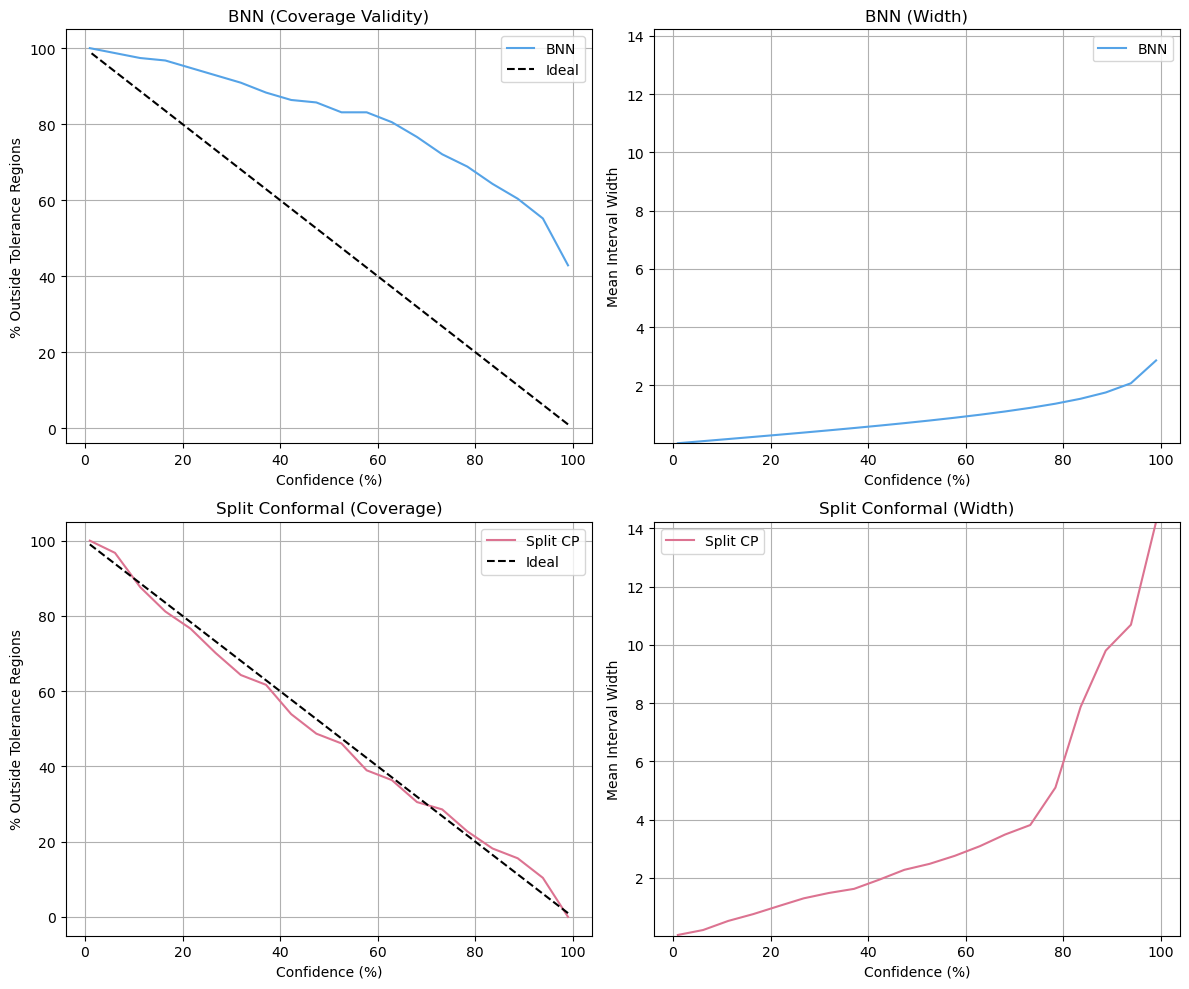

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# 假设前面已经有：
# bnn_results = [(alpha, coverage, avg_len), ...]
# cp_results  = [(alpha, coverage, avg_len), ...]

# =========================
# 整理结果为数组
# =========================
alphas = np.array([r[0] for r in bnn_results])
cov_bnn = np.array([r[1] for r in bnn_results])
w_bnn   = np.array([r[2] for r in bnn_results])

cov_cp  = np.array([r[1] for r in cp_results])
w_cp    = np.array([r[2] for r in cp_results])

conf_levels = 1 - alphas   # nominal confidence

# =========================
# 统一区间宽度 y 轴范围
# =========================
ymin = min(w_bnn.min(), w_cp.min())
ymax = max(w_bnn.max(), w_cp.max())

# =========================
# 配色
# =========================
colors = {
    "b":   "#55A3E7",   # light blue
    "pin": "#DC7391",   # rose pink
    "pur": "#9467BD"    # purple
}
palette = [colors["b"], colors["pin"], colors["pur"]]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# =========================
# Top-left: BNN (Coverage)
# =========================
ax = axes[0, 0]
ax.plot(
    conf_levels * 100,
    (1 - cov_bnn) * 100,          # % outside
    color=palette[0],
    label='BNN'
)
ax.plot(
    conf_levels * 100,
    (1 - conf_levels) * 100,      # ideal line
    'k--',
    label='Ideal'
)
ax.set_xlabel('Confidence (%)')
ax.set_ylabel('% Outside Tolerance Regions')
ax.set_title('BNN (Coverage Validity)')
ax.legend()
ax.grid(True)

# =========================
# Top-right: BNN (Width)
# =========================
ax = axes[0, 1]
ax.plot(
    conf_levels * 100,
    w_bnn,
    color=palette[0],
    label='BNN'
)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Confidence (%)')
ax.set_ylabel('Mean Interval Width')
ax.set_title('BNN (Width)')
ax.legend()
ax.grid(True)

# =========================
# Bottom-left: Split CP (Coverage)
# =========================
ax = axes[1, 0]
ax.plot(
    conf_levels * 100,
    (1 - cov_cp) * 100,
    color=palette[1],
    label='Split CP'
)
ax.plot(
    conf_levels * 100,
    (1 - conf_levels) * 100,
    'k--',
    label='Ideal'
)
ax.set_xlabel('Confidence (%)')
ax.set_ylabel('% Outside Tolerance Regions')
ax.set_title('Split Conformal (Coverage)')
ax.legend()
ax.grid(True)

# =========================
# Bottom-right: Split CP (Width)
# =========================
ax = axes[1, 1]
ax.plot(
    conf_levels * 100,
    w_cp,
    color=palette[1],
    label='Split CP'
)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Confidence (%)')
ax.set_ylabel('Mean Interval Width')
ax.set_title('Split Conformal (Width)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.savefig("../../report/figure/BNN_vs_SplitCP.png", dpi=150)
plt.show()
